In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

(4, 2) (4, 2) [0.25 0.25 0.25 0.25]


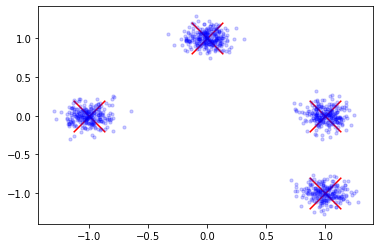

In [61]:
means = np.array([[1., 0.], [-1., 0], [0., 1.], [1, -1]])
stds = np.ones(8).reshape(4, 2)*.1
p = np.ones(4)/4.
print(means.shape, stds.shape, p)

def generate_data(n_samples):
    data = np.random.randn(n_samples, len(means), 2)
    data = data*stds+means
    
    idx = np.random.choice(np.arange(len(means)), size=n_samples, p=p)
    return data[np.arange(len(idx)), idx]
    
    
    
plt.scatter(*means.T, marker='x', color='r', s=1000)
x = generate_data(1000)
plt.scatter(*x.T, marker='o', color=(0, 0, 1., 0.2), s=10)
    


# k means clustering (teleport centroids)

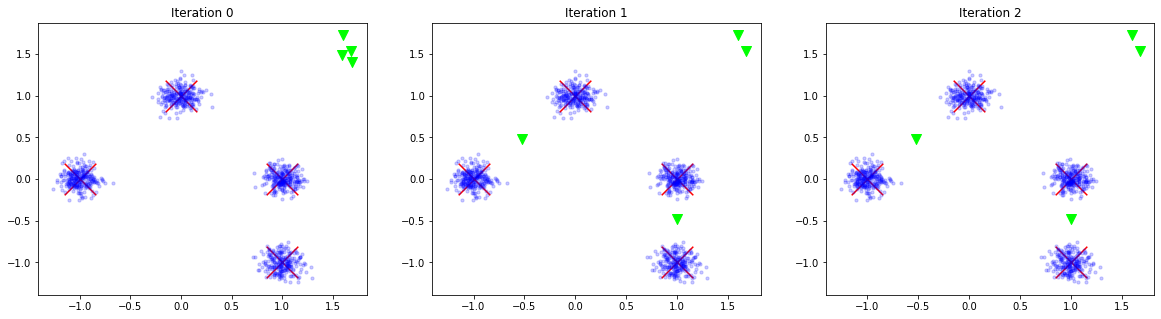

In [77]:
np.random.seed(0)
theta = np.random.randn(4, 2)/10.+1.5

x = generate_data(1000)

plt.figure(figsize=(20, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(f'Iteration {i}')
    plt.scatter(*means.T, marker='x', color='r', s=1000)
    plt.scatter(*x.T, marker='o', color=(0, 0, 1., 0.2), s=10)
    plt.scatter(*theta.T, marker='v', color=(0, 1., 0, 1.), s=100)
    
    dists = np.linalg.norm(theta[:, None, :]-x, axis=-1)
    idx = dists.argmin(axis=0)
    
    target = np.stack([x[idx==i].mean(axis=0) if (idx==i).sum()>0 else ti for i, ti in enumerate(theta)], axis=0)
    theta = target

plt.show()





# k means but with SGD

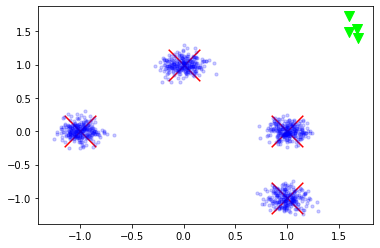

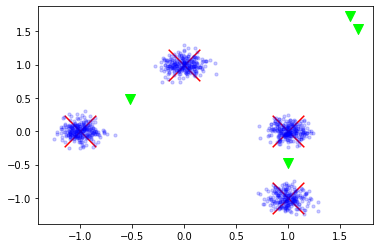

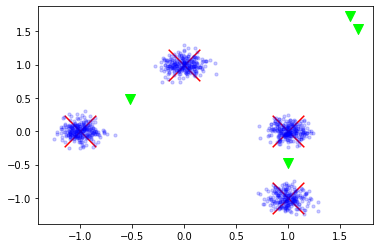

In [80]:
np.random.seed(0)

alpha = .0 # alpha=0 means the centroid teleports and becomes k means clustering
theta = np.random.randn(4, 2)/10. + 1.5

x = generate_data(1000)

for i in range(3):
    plt.scatter(*means.T, marker='x', color='r', s=1000)
    plt.scatter(*x.T, marker='o', color=(0, 0, 1., 0.2), s=10)
    plt.scatter(*theta.T, marker='v', color=(0, 1., 0, 1.), s=100)
    plt.show()
    
    dists = np.linalg.norm(theta[:, None, :]-x, axis=-1)
    idx = dists.argmin(axis=0)
    
    target = np.stack([x[idx==i].mean(axis=0) if (idx==i).sum()>0 else ti for i, ti in enumerate(theta)], axis=0)
    theta = alpha*theta + (1-alpha)*target


In [85]:
import scipy, scipy.special
scipy.special.softmax

<function scipy.special._logsumexp.softmax(x, axis=None)>

this doesn't get the double softmax idea exactly right but:

"soft k means clustering softmax"

https://www.cs.cmu.edu/~02251/recitations/recitation_soft_clustering.pdf

https://www.cs.toronto.edu/~jlucas/teaching/csc411/lectures/lec14_handout.pdf

In the second softmax step,
rather than taking another softmax (over data), they just take a weight sum (over data).
This is legal because the first softmax ensures everything is in (0,1) range.


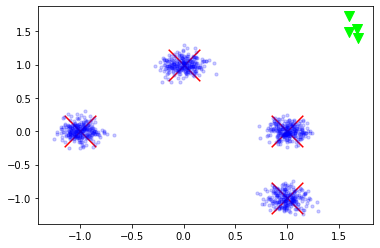

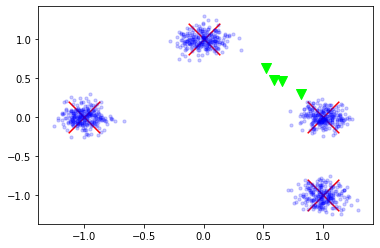

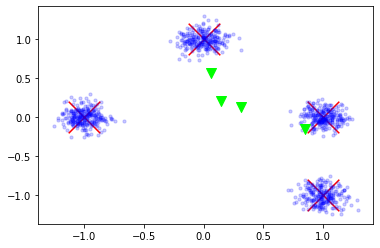

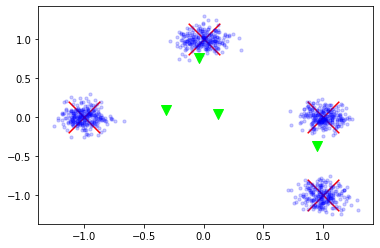

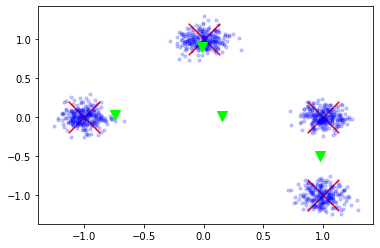

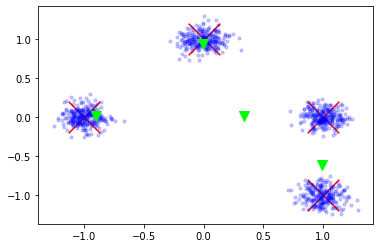

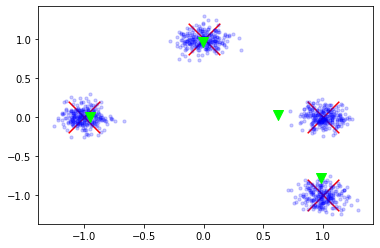

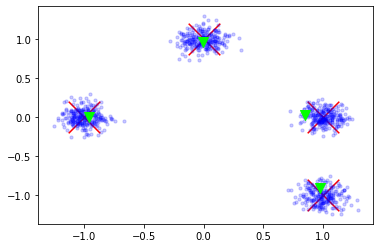

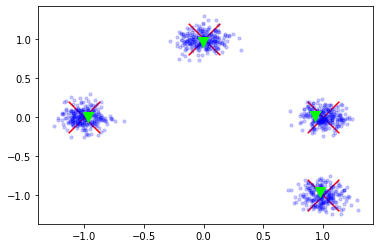

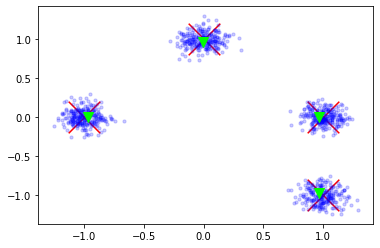

In [131]:
np.random.seed(0)

alpha = .3 # alpha=0 means the centroid teleports and becomes k means clustering
theta = np.random.randn(4, 2)/10. + 1.5

x = generate_data(1000)

for i in range(10):
    plt.scatter(*means.T, marker='x', color='r', s=1000)
    plt.scatter(*x.T, marker='o', color=(0, 0, 1., 0.2), s=10)
    plt.scatter(*theta.T, marker='v', color=(0, 1., 0, 1.), s=100)
    plt.show()
    
    beta = 5.
    dists = np.linalg.norm(theta[:, None, :]-x, axis=-1)
    # idx = dists.argmin(axis=0)
    dt = scipy.special.softmax(beta*-dists, axis=0)
    dx = scipy.special.softmax(beta*-dists, axis=1)
    # print(dx)
    # plt.plot(dx[0])
    # plt.show()
    
    # target = np.stack([x[idx==i].mean(axis=0) if (idx==i).sum()>0 else ti for i, ti in enumerate(theta)], axis=0)
    # target = np.stack([x[idx==i].mean(axis=0) if (idx==i).sum()>0 else ti for i, ti in enumerate(theta)], axis=0)
    # target = theta
    
    dtx = scipy.special.softmax(5.*dt, axis=1)
    target = dtx@x
    
    theta = alpha*theta + (1-alpha)*target

now to do with softmax attention movement and using dot product as distance with lots of clusters
and dynamically generating data for each step rather than using fixed dataset